<a href="https://colab.research.google.com/github/hafsaaaaaaaa/MLPROJECT_/blob/main/final_code_fracture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow keras opencv-python scikit-learn matplotlib numpy


In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hafsaramzanhafsa","key":"dd204805939acf6b48680031ee427a60"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bmadushanirodrigo/fracture-multi-region-x-ray-data
!unzip -q fracture-multi-region-x-ray-data.zip -d fracture_data


Dataset URL: https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data
License(s): ODC Public Domain Dedication and Licence (PDDL)
 93% 447M/481M [00:00<00:00, 413MB/s]
100% 481M/481M [00:01<00:00, 450MB/s]


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [ ]:
# === Import Libraries ===
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
# === Step 1: Dataset Paths ===
base_dir = '/content/fracture_data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
print("Train classes:", os.listdir(train_dir))  # Should show ['fractured', 'non-fractured']
print("Val classes:", os.listdir(val_dir))
print("Test classes:", os.listdir(test_dir))


Train classes: ['fractured', 'not fractured']
Val classes: ['fractured', 'not fractured']
Test classes: ['fractured', 'not fractured']


In [ ]:
# === Image Config ===
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 16

In [ ]:
# === Data Generators with Augmentation ===
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 9246 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


In [ ]:
# === Calculate Class Weights ===
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
# === Build Model ===
base_model = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# === Compile Model ===
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# === Callbacks ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_fracture_model.h5', save_best_only=True)
]


In [ ]:
# === Train Initial Model ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

# === Fine-tuning ===
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

# === Evaluation ===
y_pred = model.predict(test_generator)
y_pred_labels = (y_pred > 0.5).astype(int)

print(classification_report(test_generator.classes, y_pred_labels))
print("ROC-AUC:", roc_auc_score(test_generator.classes, y_pred))


Epoch 1/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.7550 - loss: 0.7536

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


578/578 ━━━━━━━━━━━━━━━━━━━━ 171s 296ms/step - accuracy: 0.7551 - loss: 0.7534 - val_accuracy: 0.8528 - val_loss: 0.5301 - learning_rate: 0.0010
Epoch 2/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8245 - loss: 0.5991

578/578 ━━━━━━━━━━━━━━━━━━━━ 132s 228ms/step - accuracy: 0.8246 - loss: 0.5990 - val_accuracy: 0.8938 - val_loss: 0.4594 - learning_rate: 0.0010
Epoch 3/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8542 - loss: 0.5416

578/578 ━━━━━━━━━━━━━━━━━━━━ 142s 229ms/step - accuracy: 0.8542 - loss: 0.5416 - val_accuracy: 0.8890 - val_loss: 0.4398 - learning_rate: 0.0010
Epoch 4/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8555 - loss: 0.5210

578/578 ━━━━━━━━━━━━━━━━━━━━ 132s 229ms/step - accuracy: 0.8555 - loss: 0.5210 - val_accuracy: 0.9083 - val_loss: 0.4140 - learning_rate: 0.0010
Epoch 5/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8698 - loss: 0.5060

578/578 ━━━━━━━━━━━━━━━━━━━━ 132s 228ms/step - accuracy: 0.8698 - loss: 0.5060 - val_accuracy: 0.9107 - val_loss: 0.4031 - learning_rate: 0.0010
Epoch 6/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 129s 224ms/step - accuracy: 0.8694 - loss: 0.4981 - val_accuracy: 0.9240 - val_loss: 0.4052 - learning_rate: 0.0010
Epoch 7/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8797 - loss: 0.4763

578/578 ━━━━━━━━━━━━━━━━━━━━ 133s 230ms/step - accuracy: 0.8797 - loss: 0.4763 - val_accuracy: 0.9264 - val_loss: 0.3912 - learning_rate: 0.0010
Epoch 8/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 132s 228ms/step - accuracy: 0.8785 - loss: 0.4868 - val_accuracy: 0.9144 - val_loss: 0.4069 - learning_rate: 0.0010
Epoch 9/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8792 - loss: 0.4796

578/578 ━━━━━━━━━━━━━━━━━━━━ 132s 228ms/step - accuracy: 0.8792 - loss: 0.4797 - val_accuracy: 0.9276 - val_loss: 0.3900 - learning_rate: 0.0010
Epoch 10/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8726 - loss: 0.4915

578/578 ━━━━━━━━━━━━━━━━━━━━ 133s 229ms/step - accuracy: 0.8726 - loss: 0.4915 - val_accuracy: 0.9204 - val_loss: 0.3888 - learning_rate: 0.0010
Epoch 11/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8716 - loss: 0.4874

578/578 ━━━━━━━━━━━━━━━━━━━━ 131s 227ms/step - accuracy: 0.8716 - loss: 0.4874 - val_accuracy: 0.9397 - val_loss: 0.3883 - learning_rate: 0.0010
Epoch 12/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 131s 226ms/step - accuracy: 0.8785 - loss: 0.4867 - val_accuracy: 0.9312 - val_loss: 0.3895 - learning_rate: 0.0010
Epoch 13/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8675 - loss: 0.4931

578/578 ━━━━━━━━━━━━━━━━━━━━ 132s 229ms/step - accuracy: 0.8675 - loss: 0.4931 - val_accuracy: 0.9240 - val_loss: 0.3816 - learning_rate: 0.0010
Epoch 14/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 132s 228ms/step - accuracy: 0.8798 - loss: 0.4814 - val_accuracy: 0.9312 - val_loss: 0.3826 - learning_rate: 0.0010
Epoch 15/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 130s 226ms/step - accuracy: 0.8778 - loss: 0.4760 - val_accuracy: 0.9192 - val_loss: 0.3869 - learning_rate: 0.0010
Epoch 1/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 336s 366ms/step - accuracy: 0.7625 - loss: 0.8601 - val_accuracy: 0.9095 - val_loss: 0.4207 - learning_rate: 1.0000e-05
Epoch 2/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9051 - loss: 0.4458

578/578 ━━━━━━━━━━━━━━━━━━━━ 146s 253ms/step - accuracy: 0.9052 - loss: 0.4458 - val_accuracy: 0.9324 - val_loss: 0.3497 - learning_rate: 1.0000e-05
Epoch 3/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9391 - loss: 0.3594

578/578 ━━━━━━━━━━━━━━━━━━━━ 148s 255ms/step - accuracy: 0.9391 - loss: 0.3593 - val_accuracy: 0.9530 - val_loss: 0.3001 - learning_rate: 1.0000e-05
Epoch 4/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9579 - loss: 0.3109

578/578 ━━━━━━━━━━━━━━━━━━━━ 158s 272ms/step - accuracy: 0.9579 - loss: 0.3108 - val_accuracy: 0.9650 - val_loss: 0.2725 - learning_rate: 1.0000e-05
Epoch 5/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9728 - loss: 0.2681

578/578 ━━━━━━━━━━━━━━━━━━━━ 195s 259ms/step - accuracy: 0.9728 - loss: 0.2681 - val_accuracy: 0.9710 - val_loss: 0.2590 - learning_rate: 1.0000e-05
Epoch 6/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9754 - loss: 0.2616

578/578 ━━━━━━━━━━━━━━━━━━━━ 152s 262ms/step - accuracy: 0.9754 - loss: 0.2616 - val_accuracy: 0.9783 - val_loss: 0.2442 - learning_rate: 1.0000e-05
Epoch 7/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9819 - loss: 0.2485

578/578 ━━━━━━━━━━━━━━━━━━━━ 203s 264ms/step - accuracy: 0.9819 - loss: 0.2485 - val_accuracy: 0.9831 - val_loss: 0.2303 - learning_rate: 1.0000e-05
Epoch 8/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9837 - loss: 0.2381

578/578 ━━━━━━━━━━━━━━━━━━━━ 154s 266ms/step - accuracy: 0.9837 - loss: 0.2381 - val_accuracy: 0.9879 - val_loss: 0.2232 - learning_rate: 1.0000e-05
Epoch 9/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9865 - loss: 0.2257

578/578 ━━━━━━━━━━━━━━━━━━━━ 153s 265ms/step - accuracy: 0.9865 - loss: 0.2257 - val_accuracy: 0.9879 - val_loss: 0.2192 - learning_rate: 1.0000e-05
Epoch 10/10
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9809 - loss: 0.2401

578/578 ━━━━━━━━━━━━━━━━━━━━ 152s 262ms/step - accuracy: 0.9809 - loss: 0.2401 - val_accuracy: 0.9928 - val_loss: 0.2112 - learning_rate: 1.0000e-05
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 476ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       238
           1       1.00      1.00      1.00       268

    accuracy                           1.00       506
   macro avg       1.00      1.00      1.00       506
weighted avg       1.00      1.00      1.00       506

ROC-AUC: 0.9999372883481751


In [ ]:
print(train_generator.class_indices)


{'fractured': 0, 'not fractured': 1}


In [ ]:
def predict_image(img_path, model):
    from tensorflow.keras.preprocessing import image
    import matplotlib.pyplot as plt
    import numpy as np
    import tensorflow as tf
    from PIL import Image

    # Load image and convert to RGB
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img)

    # Show image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Preprocess
    img_array = tf.keras.applications.efficientnet_v2.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)[0][0]

    # FIXED: fractured = 0, not fractured = 1
    label = "Fractured" if prediction < 0.5 else "Not Fractured"

    print(f"Prediction: {label} (Raw Score: {prediction:.4f})")


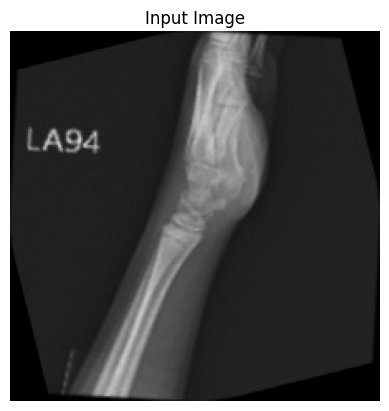

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction: Not Fractured (Raw Score: 0.9982)


In [ ]:
predict_image("/content/fracture_data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/33-rotated1-rotated2-rotated2-rotated1.jpg", model)


In [ ]:
model.save("fracture_model.keras")  # Saved as a directory


In [ ]:
import datetime
import requests
import subprocess
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model

# --- Load Keras Model (.h5) ---
def load_model_keras(model_path):
    return load_model(model_path)

# --- Preprocess Image & Predict with Visualization ---
def predict_image(img_path, model):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img)

    # Show image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Preprocess for EfficientNetV2
    img_array = tf.keras.applications.efficientnet_v2.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)[0][0]

    # fractured = 0, not fractured = 1
    label = "Fractured" if prediction < 0.5 else "Not Fractured"
    confidence = 1 - prediction if label == "Fractured" else prediction

    print(f"Prediction: {label} (Confidence: {confidence:.4f})")
    return label, confidence
# --- GROQ Report Generator ---
def get_report_from_grok(disease, kb_text, grok_api_key):
    headers = {
        "Authorization": f"Bearer {grok_api_key}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "llama3-8b-8192",
        "temperature": 0.3,
        "max_tokens": 1000,
        "top_p": 0.95,
        "messages": [
            {
                "role": "user",
                "content": f"""
You are a radiologist. From the knowledge base below, generate a professional radiology report for the case: {disease}.

Use the following LaTeX-style format:
\\section*{{Radiological Findings}}
\\section*{{Recommendations}}
\\section*{{Prescription / Treatment}}
\\section*{{Additional Notes}}

Exclude introductory lines like "Here is the radiology report for..."

Knowledge Base:
{kb_text}
"""
            }
        ]
    }
    response = requests.post("https://api.groq.com/openai/v1/chat/completions", headers=headers, json=payload)
    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        raise Exception(f"Grok API Error {response.status_code}: {response.text}")


# --- Wrap Report in LaTeX ---
def wrap_in_latex(report_text, radiologist_name="Dr. Hafsa Ramzan", disease="Unknown"):
    now = datetime.datetime.now()
    return rf"""
\\documentclass[12pt]{{article}}
\\usepackage[margin=1in]{{geometry}}
\\usepackage{{parskip}}
\\usepackage{{titlesec}}
\\titleformat{{\\section}}[block]{{\\Large\\bfseries}}{{\\thesection}}{{1em}}{{}}

\\begin{{document}}

\\begin{{center}}
    \\Huge\\textbf{{Radiology Report}} \\\\
    \\vspace{{0.5cm}}
    \\large\\textbf{{Radiologist:}} {radiologist_name} \\\\
    \\large\\textbf{{Date:}} {now.strftime('%Y-%m-%d')} \\\\
    \\large\\textbf{{Time:}} {now.strftime('%H:%M:%S')}
\\end{{center}}

\\vspace{{1cm}}

\\section*{{Detected Case: {disease}}}

{report_text}

\\end{{document}}
"""

# --- Save as PDF ---
def save_as_pdf(latex_code, output_name="radiology_report"):
    tex_file = f"{output_name}.tex"
    with open(tex_file, "w") as f:
        f.write(latex_code)
    try:
        subprocess.run(["pdflatex", tex_file], check=True)
        print(f"✅ PDF generated: {output_name}.pdf")
    except FileNotFoundError:
        print("❌ LaTeX not installed. Install it via: !apt install texlive-xetex")
    except subprocess.CalledProcessError:
        print("❌ PDF compilation failed.")
    for ext in [".aux", ".log", ".tex"]:
        try: os.remove(f"{output_name}{ext}")
        except: pass

# --- Main Wrapper Function ---
def generate_radiology_report_keras(model_path, image_path, kb_path, grok_api_key, radiologist_name="Dr. Hafsa Ramzan"):
    model = load_model_keras(model_path)
    disease, confidence = predict_image(image_path, model)
    print(f"\\n🔍 Detected: {disease} (Confidence: {confidence:.4f})")

    with open(kb_path, 'r') as f:
        kb_text = f.read()

    report = get_report_from_grok(disease, kb_text, grok_api_key)
    latex_code = wrap_in_latex(report, radiologist_name, disease)
    save_as_pdf(latex_code)


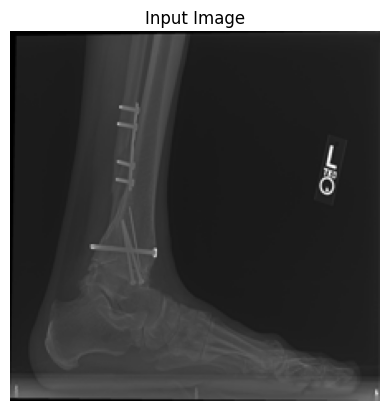

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Prediction: Fractured (Confidence: 0.9988)
\n🔍 Detected: Fractured (Confidence: 0.9988)


Exception: Grok API Error 400: {"error":{"message":"Organization has been restricted. Please reach out to support if you believe this was in error.","type":"invalid_request_error","code":"organization_restricted"}}


In [ ]:
generate_radiology_report_keras(
    model_path="/content/best_fracture_model.h5",
    image_path="/content/fracture_data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/fractured/0045.png",
    kb_path="/content/database fracture.txt",
    grok_api_key="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",

    radiologist_name="Dr. Hafsa Ramzan"
)
